## Data Preprocessing

In [10]:
# Imports
import numpy as np
import pandas as pd
# import dcMinMaxFunctions as dc
# import dcor
from scipy.misc import derivative
from sklearn.model_selection import train_test_split
import math
import torch
from scipy import stats
import wandb

In [11]:
df=pd.read_csv("data/Churn_Modelling.csv")

In [12]:
df

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [13]:
n=1000
d=12
n**(-1./(d+4))


0.6493816315762113

In [14]:
df=pd.read_csv("data/Churn_Modelling.csv")
# df=df.drop(['duration', 'pdays'],axis=1) # duration gives away the answer, and pdays has too much missing info

X = df.loc[:, df.columns != 'Exited'].replace(dict(yes=True, no=False))
Y = df.loc[:, ['Exited']].replace(dict(yes=True, no=False))

In [15]:
categorical_columns = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']
numerical_columns = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
outputs = ['Exited']

In [16]:
for category in categorical_columns:
    df[category] = df[category].astype('category')

In [17]:
def OHE(x):
    dim = np.max(x)
    y = np.zeros((len(x),dim+1))
    for i in range(len(x)):
        y[i][x[i]] = 1
    return(y)

In [18]:
geo = OHE(df['Geography'].cat.codes.values)
gen =  np.asarray(df['Gender'].cat.codes.values)
hcc =  np.asarray(df['HasCrCard'].cat.codes.values)
iam =  np.asarray(df['IsActiveMember'].cat.codes.values)

categorical_data = np.stack(( gen, hcc, iam), axis=1)
# categorical_data = torch.tensor(categorical_data, dtype=torch.int64)
numerical_data = np.stack([df[col].values for col in numerical_columns], 1)
# numerical_data = torch.tensor(numerical_data, dtype=torch.float)
X = np.concatenate((numerical_data, categorical_data,geo), axis=1)
Y = df[outputs].values
# outputs = torch.tensor(df[outputs].values).flatten()

In [19]:
def normalize(x):
    x_normed = x / x.max(0, keepdim=True)[0]
    return x_normed



In [20]:
X = torch.Tensor(X)
Y = torch.Tensor(Y)
X = normalize(X)

In [21]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

## Estimating Data Densities

#### Gaussian Kernel Density Estimation & Derivative

In [22]:
def gau_ker(u):
    return torch.pow(2*torch.tensor(torch.pi),u.shape[1]/(-2))*torch.exp(torch.bmm(u.view(u.shape[0], 1, u.shape[1]), u.view(u.shape[0],  u.shape[1],1))/(-2))


def py_kde(x,X_t,h):
    norm = X_t.shape[0]*(h**x.shape[1])
    prob = torch.zeros(x.shape[0]).cuda()
    for i in range(len(X_t)):
        prob+= (torch.squeeze(gau_ker((x - X_t[i])/h))/norm).cuda()
    return(prob)


def py_kde_der(p_x,x):
    # x.requires_grad = True
    # p_x = py_kde(x,X_t,h)
    return (torch.autograd.grad(p_x,x,torch.ones_like(p_x),allow_unused=True,create_graph=True)[0]).cuda()


def gau_ker_der(X,h):
    N= X.shape[0]
    d = X.shape[1]
    grad = torch.zeros(X.shape)
    for n in range(N):
        for i in range(d):
            for j in range(N):
                grad[n][i]+= torch.exp(-1*torch.dot((X[n]-X[j]),(X[n]-X[j]))/(2*h*h))*(X[n][i] -X[j][i]) /(N*(h**(d+2))*((2*math.pi)**(d/2)))

    return grad

#### Confidence Intervals

In [23]:

def CI_KDE(p_x,n,h,d,alpha):
    return( stats.norm.ppf(1-alpha/2)*torch.sqrt(p_x/((2**d)*math.sqrt(torch.pi**d)*n*h**(d))) )

def CI_KDE_der(p_x_der,p_x,n,h,d,alpha):
    return( p_x_der*stats.norm.ppf(1-alpha/2)*torch.sqrt(1/(p_x.unsqueeze(dim=1)*(2**d)*math.sqrt(torch.pi**d)*n*h**(d))) )

#### Example on Data

In [24]:
h=0.65
x = X[0:1000].detach().cuda()
x.requires_grad = True
f = py_kde(x,x,h)
f_der = py_kde_der(f,x)

In [25]:
n = X.shape[0]
d = X.shape[1]
alpha =0.0001

In [26]:
ci = CI_KDE(f,n,h,d,alpha)
ci_der = CI_KDE_der(f_der,f,n,h,d,alpha)

In [27]:
torch.norm((ci_der/f.view(-1,1))[0])

tensor(0.0403, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)

In [28]:
torch.norm(ci_der/f.view(-1,1))

tensor(1.8513, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)

In [29]:
ci_der

tensor([[ 6.8255e-07, -5.1870e-07,  5.3233e-06,  ..., -1.8655e-06,
          8.5586e-07,  1.0096e-06],
        [ 6.5446e-07, -1.2829e-07,  4.2369e-06,  ...,  1.6794e-06,
          1.0232e-06, -2.7026e-06],
        [ 3.0163e-06, -7.6364e-07, -4.3834e-06,  ..., -1.9228e-06,
          1.1064e-06,  8.1638e-07],
        ...,
        [ 1.0246e-06, -3.1481e-06, -2.0484e-06,  ...,  1.6132e-06,
          8.9832e-07, -2.5115e-06],
        [-2.8924e-06,  1.7713e-06,  1.2602e-06,  ...,  1.8684e-06,
         -2.9437e-06,  1.0753e-06],
        [-2.0102e-06,  1.4673e-07,  5.4403e-06,  ..., -1.5799e-06,
          8.3815e-07,  7.4178e-07]], device='cuda:0', grad_fn=<MulBackward0>)

In [30]:
ci_der[0]/float(f[0])

tensor([ 0.0024, -0.0018,  0.0184,  0.0164,  0.0092, -0.0019,  0.0221, -0.0084,
        -0.0174, -0.0064,  0.0030,  0.0035], device='cuda:0',
       grad_fn=<DivBackward0>)

## Training the model

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class Net(nn.Module):
    def __init__(self,p):
        super(Net, self ).__init__()
        
        self.loss_reg = 0
        self.p =p 
        self.x = 0
        self.y = 0
        self.H_net1 = nn.Sequential(
            nn.Linear(12, 48),
            nn.Sigmoid(),
            nn.Linear(48, 24),
            nn.Sigmoid(),
            nn.Linear(24, 144).cuda()

        )
        self.X_net = nn.Sequential(
            nn.Linear(12, 16),
            nn.ReLU(),
            # nn.Linear(48, 48),
            # nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()

        )
        
    def forward(self, x):
        def H_mul(z):
            H12 = self.H_net1(z)
            H12= H12.reshape(z.shape[0],d,d)
            x12 = torch.matmul(z,H12)
            return(x12)
    
        
        def batch_jacobian(func, z, create_graph=False):
            # x in shape (Batch, Length)
            def _func_sum(z):
                return func(z).sum(dim=0)
            return torch.squeeze(torch.autograd.functional.jacobian(_func_sum, z, create_graph=create_graph)).permute(1,0,2)
        
        x.requires_grad =True
        p = self.p
        self.x = x
        d = x.shape[1]
        bs = x.shape[0]
        x= torch.unsqueeze(x,1)
        z = x.cuda()
        loss_reg = torch.zeros(bs,d).cuda()
        for i in range(p):
            H = self.H_net1(z).cuda()
            H = H.reshape(bs,d,d)
            z = torch.matmul(z,H).cuda()
            J = batch_jacobian(H_mul, z, create_graph=True)
            J_int =-torch.log(torch.abs(torch.det(J)))
            loss_reg = loss_reg + torch.squeeze(torch.autograd.grad(J_int, x,torch.ones_like(J_int),allow_unused=True,create_graph= True)[0]).cuda()
        self.loss_reg = loss_reg
        self.y = z
        y = self.X_net(z)
        return y

In [32]:
net = Net(10).cuda()
net(X_train[0:3].cuda())

tensor([[[0.7670]],

        [[0.5325]],

        [[0.9684]]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [33]:
net.loss_reg - f_der[0:3]/f[0:3].view(f[0:3].shape[0],1)

tensor([[  0.2150,   0.0528,  -1.4557,  -0.8471,  -0.1672,   0.2958,  -1.3538,
           0.3180,   0.4657,   0.2482,  -0.3461,  -0.2947],
        [ -1.4400,  -0.9708,  -2.4521,   5.6186,  -0.1683,   0.3752,  -3.5791,
          -0.9337,  -4.5138,  -3.1731,  -0.5164,  -3.8039],
        [-33.7263,  24.5918,  16.5738, -42.7060, -22.5589,  12.1098,   4.1549,
         -13.3294,  39.4987,  16.8790,  18.9683,  15.5196]], device='cuda:0',
       grad_fn=<SubBackward0>)

In [34]:
import torch.optim as optim

criterion = nn.BCELoss(reduction= 'none')
def my_loss(y_pred,y_train,reg_loss):
    loss = criterion(y_pred,y_train) +reg_loss
    return loss
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
torch.autograd.set_detect_anomaly(False)
net_5 = Net(10)
import torch.optim.lr_scheduler as lr_scheduler
 


In [35]:
def train_model_priv(net,trainloader,optimizer,epochs,h,rate=10,device= torch.device('cpu'),print_cond = True,only_reg_flag=0):
    # scheduler = lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
    for epoch in range(epochs):  # loop over the dataset multiple times
        # scheduler.step()
        running_loss = 0.0
        net = net.to(device)
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            
            inputs = data[0].to(device)
            inputs.requires_grad = True
            labels = data[1].to(device)
            f = py_kde(inputs,inputs,h)
            f_der = py_kde_der(f,inputs)
          
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = net(inputs)
            if(only_reg_flag):
                loss = torch.norm(f_der/f.view(f.shape[0],1)+ net.loss_reg,dim=1)
            else:
                loss = criterion(torch.squeeze(outputs),torch.squeeze(labels)) + torch.norm(f_der/f.view(f.shape[0],1)+ net.loss_reg,dim=1)
            loss.backward(torch.ones_like(loss),retain_graph=True)
            optimizer.step()

      
            # print statistics
            # print(loss.sum().shape)
            running_loss += loss.sum()
            # if i % 100 == 99:    # print every 2000 mini-batches
        if(epoch%rate==rate-1):
            if(print_cond):
                print('%d loss: %.10f' %
                        (epoch + 1, running_loss /(rate*len(trainloader.dataset))))
                running_loss = 0.0

    print('Finished Training')


In [36]:
#write torch.adam optimizer which first warms up and then decays




In [37]:
train = torch.utils.data.TensorDataset(X_train,Y_train)
train_priv = torch.utils.data.TensorDataset(X,Y)

trainloader_priv = torch.utils.data.DataLoader(train_priv, batch_size=1000,
                                          shuffle=True, num_workers=2)
net_5 = Net(3)
optim = torch.optim.Adam(net_5.parameters(),lr=0.01)
train_model_priv(net_5,trainloader_priv,optim,5,h=0.65,rate=1,device=torch.device('cuda'),only_reg_flag=1)

1 loss: 3.8269534111
2 loss: 3.0497708321
3 loss: 2.9040632248
4 loss: 2.7770833969
5 loss: 2.6772150993
Finished Training


In [34]:
optim = torch.optim.Adam(net_5.parameters(),lr=0.01)
train_model_priv(net_5,trainloader_priv,optim,30,h=0.65,rate=1,device=torch.device('cuda'),only_reg_flag=1)

1 loss: 2.8099992275
2 loss: 2.4453482628
3 loss: 2.0053462982
4 loss: 1.8305778503
5 loss: 1.4373526573
6 loss: 1.2463039160
7 loss: 1.0928441286
8 loss: 1.0100624561
9 loss: 0.9492591619
10 loss: 0.9543683529
11 loss: 0.8591307402
12 loss: 0.8429867029
13 loss: 0.8223188519
14 loss: 0.8133831620
15 loss: 0.7906615734
16 loss: 0.7793525457
17 loss: 0.7564795017
18 loss: 0.7168283463
19 loss: 0.7477931976
20 loss: 0.7275117636
21 loss: 0.7567098737
22 loss: 0.7445353866
23 loss: 0.7447450757
24 loss: 0.7080577016
25 loss: 0.6747940183
26 loss: 0.6519592404
27 loss: 0.6679731011
28 loss: 0.7095085979
29 loss: 0.7323722243
30 loss: 0.6936945319
Finished Training


In [35]:
train_model_priv(net_5,trainloader_priv,optim,20,h=0.65,rate=1,device=torch.device('cuda'),only_reg_flag=0)

1 loss: 1.2841753960
2 loss: 1.1753804684
3 loss: 1.1426836252
4 loss: 1.1374456882
5 loss: 1.1311126947
6 loss: 1.0961644650
7 loss: 1.1231994629
8 loss: 1.1206990480
9 loss: 1.1151359081
10 loss: 1.0391232967
11 loss: 1.0263444185
12 loss: 1.0227079391
13 loss: 1.0137541294
14 loss: 0.9767276049
15 loss: 1.0190696716
16 loss: 1.0212602615
17 loss: 0.9718999863
18 loss: 1.0058130026
19 loss: 0.9561971426
20 loss: 0.9638320804
Finished Training


In [36]:
optim = torch.optim.Adam(net_5.parameters(),lr=0.003)
train_model_priv(net_5,trainloader_priv,optim,10,h=0.65,rate=1,device=torch.device('cuda'),only_reg_flag=0)

1 loss: 1.0279887915
2 loss: 0.8758187294
3 loss: 0.8489959836
4 loss: 0.8448605537
5 loss: 0.8281965852
6 loss: 0.8061122298
7 loss: 0.8135287762
8 loss: 0.8008967638
9 loss: 0.8267527223
10 loss: 0.8310554624
Finished Training


In [ ]:
#write function to save net_5 model
# torch.save(net_5.state_dict(), "net_5.pth")
# not just weights but entire modek
torch.save(net_5, "Models/net_6_complete")

## Upper bound on Epsilon


In [37]:
data=X

# m1 = torch.load("Models/net_5_5.pth")
m1 = net_5
losses= torch.zeros(X.shape[0])
bs = 1000
n = bs
h = 0.65
d = X.shape[1]
alpha= 0.0001
for ct in range(0,len(X),bs):
    x = data[ct:bs+ct].detach()
    x_hat = m1(x)
    f = py_kde(x,x,0.65)
    f_der = py_kde_der(f,x)
    ci = CI_KDE(f,n,h,d,alpha)
    ci_der = CI_KDE_der(f_der,f,n,h,d,alpha)
    loss =torch.max(torch.linalg.norm(f_der/(f-ci).view(f.shape[0],1)+m1.loss_reg,dim=1),torch.linalg.norm(f_der/(f+ci).view(f.shape[0],1)+m1.loss_reg,dim=1)) + torch.norm(ci_der/f.view(-1,1),dim=1)
    losses[ct:bs+ct] =loss

In [40]:
losses

tensor([0.2897, 0.3066, 0.3142,  ..., 1.8749, 1.9794, 1.9876],
       grad_fn=<SortBackward0>)

In [39]:
#arrange X and Y in ascending order of losses
losses,indices = torch.sort(losses)
X = X[indices]
Y = Y[indices]


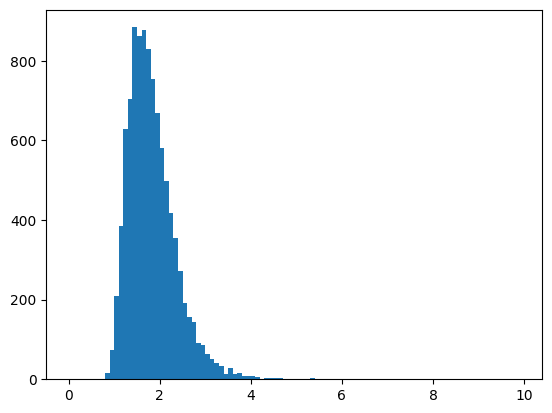

In [41]:

from matplotlib import pyplot as plt
import numpy as np
 
 
# Creating dataset
a = losses.detach()[0:10000]*2.7
 
# Creating histogram
fig, ax = plt.subplots()
ax.hist(a, bins = np.arange(0,10,0.1))
 
# Show plot
plt.show()

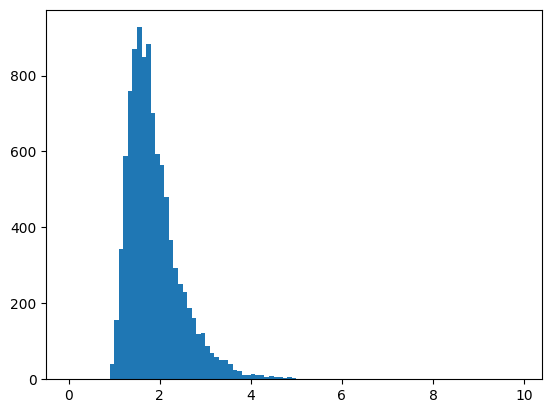

In [ ]:

from matplotlib import pyplot as plt
import numpy as np
 
 
# Creating dataset
a = losses.detach()[0:10000]*2.7
 
# Creating histogram
fig, ax = plt.subplots()
ax.hist(a, bins = np.arange(0,10,0.1))
 
# Show plot
plt.show()

In [ ]:
set_eps = 2
ind =(losses*2.7 < set_eps).sum()



In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X[0:ind], Y[0:ind], test_size=0.2)
print(len(X_train))
o = m1(X_train.detach())
X_emb_train = torch.squeeze(m1.y).detach()
o = m1(X_test.detach())
X_emb_test = torch.squeeze(m1.y).detach()
o = m1(X[ind:-1].detach())
X_emb_test2 = torch.squeeze(m1.y).detach()
Y_test2 = Y[ind:-1]

5369


In [ ]:

# o = autoencoder1(X)
# X_embs = torch.squeeze(autoencoder1.y.detach())
model = nn.Sequential(
    nn.Linear(12, 16),
    nn.ReLU(),
    # nn.Linear(48, 64),
    nn.ReLU(),
    # nn.Linear(64, 64),
    # nn.ReLU(),
    # nn.Linear(64, 32),
    # nn.ReLU(),
    nn.Linear(16, 1),
    nn.Sigmoid(

    )
)
model = model.cuda()
loss_fn = nn.BCELoss()  # binary cross entropy
# import torch.optim as optim
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay= 1e-4)
n_epochs = 1000
batch_size = 1000

for epoch in range(n_epochs):
    for i in range(0, len(X_emb_train), batch_size):
        Xbatch = X_emb_train[i:i+batch_size]
        y_pred = model(Xbatch)
        ybatch = Y_train[i:i+batch_size]
        loss = loss_fn(y_pred.cuda(), ybatch.cuda())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    #     print(loss)
    # print(f'Finished epoch {epoch}, latest loss {loss}')
# compute accuracy (no_grad is optional)
    if(epoch%100==99):
        with torch.no_grad():
            y_pred = model(X_emb_train)
            accuracy = (y_pred.round() == Y_train.cuda()).float().mean()
            print(f"Train Accuracy {accuracy}",len(X_emb_train))
            y_pred = model(X_emb_test)
            accuracy = (y_pred.round() == Y_test.cuda()).float().mean()
            print(f"Test Accuracy {accuracy}")
            y_pred = model(X_emb_test2)
            accuracy = (y_pred.round() == Y_test2.cuda()).float().mean()
            # print(f"Test Accuracy 2 {accuracy}")

# with torch.no_grad():
#     y_pred = model(X_emb_test)
 


Train Accuracy 0.8696219325065613 5369
Test Accuracy 0.8585256934165955
Train Accuracy 0.8752095699310303 5369
Test Accuracy 0.8585256934165955
Train Accuracy 0.8763270974159241 5369
Test Accuracy 0.8570365309715271
Train Accuracy 0.8781896233558655 5369
Test Accuracy 0.8600149154663086
Train Accuracy 0.8787484169006348 5369
Test Accuracy 0.8622487187385559
Train Accuracy 0.8783758878707886 5369
Test Accuracy 0.8585256934165955
Train Accuracy 0.8794934153556824 5369
Test Accuracy 0.8607594966888428
Train Accuracy 0.8791208863258362 5369
Test Accuracy 0.8607594966888428
Train Accuracy 0.8794934153556824 5369
Test Accuracy 0.8607594966888428
Train Accuracy 0.8796796798706055 5369
Test Accuracy 0.8592703342437744


In [ ]:
with torch.no_grad():
    y_pred = model(X_emb_test2)
    accuracy = (y_pred.round() == Y_ test2.cuda()).float().mean()
    print(f"Accuracy {accuracy}")

In [ ]:
ind

In [ ]:
# code to split test train 

X_train, X_test, Y_train, Y_test = train_test_split(X[0:ind], Y[0:ind], test_size=0.2)
X_test2 = X[ind:-1]
Y_test2 = Y[ind:-1]

In [ ]:
model1 = nn.Sequential(
    nn.Linear(12, 48),
    nn.ReLU(),
    nn.Linear(48, 32),
    nn.ReLU(),
    nn.Linear(32, 1),
    nn.Sigmoid(

    )
)
loss_fn = nn.BCELoss()  # binary cross entropy

optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.01)
n_epochs = 100
batch_size = 1000
 
for epoch in range(n_epochs):
    for i in range(0, len(X_train), batch_size):
        Xbatch = X_train[i:i+batch_size]
        y_pred = model1(Xbatch)
        ybatch = Y_train[i:i+batch_size]
        loss = loss_fn(y_pred, ybatch)
        optimizer1.zero_grad()
        loss.backward()
        optimizer1.step()

with torch.no_grad():
    y_pred = model1(X_test)
 
accuracy = (y_pred.round() == Y_test).float().mean()
print(f"Accuracy {accuracy}")
with torch.no_grad():
    y_pred = model1(X_test2)
 
accuracy = (y_pred.round() == Y_test2).float().mean()
print(f"Accuracy {accuracy}")

Accuracy 0.869694709777832
Accuracy 0.7776087522506714


In [ ]:
#jumble orders of X keeping corresponding Y same
indices = torch.randperm(X.shape[0])
X = X[indices]
Y = Y[indices]
X_train, X_test, Y_train, Y_test = train_test_split(X[0:ind], Y[0:ind], test_size=0.2)
X_test2 = X[ind:-1]
Y_test2 = Y[ind:-1]



In [ ]:
model1 = nn.Sequential(
    nn.Linear(12, 48),
    nn.ReLU(),
    nn.Linear(48, 32),
    nn.ReLU(),
    nn.Linear(32, 1),
    nn.Sigmoid(

    )
)
loss_fn = nn.BCELoss()  # binary cross entropy

optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.01)
n_epochs = 100
batch_size = 1000
 
for epoch in range(n_epochs):
    for i in range(0, len(X_train), batch_size):
        Xbatch = X_train[i:i+batch_size]
        y_pred = model1(Xbatch)
        ybatch = Y_train[i:i+batch_size]
        loss = loss_fn(y_pred, ybatch)
        optimizer1.zero_grad()
        loss.backward()
        optimizer1.step()

with torch.no_grad():
    y_pred = model1(X_test)
 
accuracy = (y_pred.round() == Y_test).float().mean()
print(f"Accuracy {accuracy}")
with torch.no_grad():
    y_pred = model1(X_test2)
 
accuracy = (y_pred.round() == Y_test2).float().mean()
print(f"Accuracy {accuracy}")

Accuracy 0.8577811121940613
Accuracy 0.85123211145401
